In [1]:
from keras.models import Sequential,Model
from keras.layers.core import Dense, Dropout, Activation, Flatten, MaxoutDense
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD, Adadelta, Adagrad
from keras.utils import np_utils, generic_utils
from keras.callbacks import EarlyStopping
from keras.layers.advanced_activations import PReLU, LeakyReLU
from keras.layers import Embedding,GRU,TimeDistributed,RepeatVector,Merge,Input,merge,UpSampling2D,BatchNormalization

from keras.preprocessing.text import one_hot
from keras.preprocessing import sequence
import numpy as np

from os import listdir
from os.path import isfile, join

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import PIL.Image

import json
from tqdm import tqdm

from keras.optimizers import SGD, RMSprop, Adam

from utils import *
import cPickle as pickle
from matplotlib import pyplot as plt

from itertools import compress

import shutil
import string

import collections

import matplotlib.patches as patches

import os

from keras import callbacks

Using Theano backend.
Using gpu device 0: GeForce GTX 1080 (CNMeM is disabled, cuDNN 5110)
/opt/conda/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


In [2]:
def get_unet(img_rows, img_cols):
    
    
    inputs = Input((3, img_rows, img_cols))
    bn = BatchNormalization()(inputs)
    conv1 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(bn)
    conv1 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(pool1)
    conv2 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(pool2)
    conv3 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Convolution2D(256, 3, 3, activation='relu', border_mode='same')(pool3)
    conv4 = Convolution2D(256, 3, 3, activation='relu', border_mode='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Convolution2D(512, 3, 3, activation='relu', border_mode='same')(pool4)
    conv5 = Convolution2D(512, 3, 3, activation='relu', border_mode='same')(conv5)

    up6 = merge([UpSampling2D(size=(2, 2))(conv5), conv4], mode='concat', concat_axis=1)
    conv6 = Convolution2D(256, 3, 3, activation='relu', border_mode='same')(up6)
    conv6 = Convolution2D(256, 3, 3, activation='relu', border_mode='same')(conv6)

    up7 = merge([UpSampling2D(size=(2, 2))(conv6), conv3], mode='concat', concat_axis=1)
    conv7 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(up7)
    conv7 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(conv7)

    up8 = merge([UpSampling2D(size=(2, 2))(conv7), conv2], mode='concat', concat_axis=1)
    conv8 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(up8)
    conv8 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(conv8)

    up9 = merge([UpSampling2D(size=(2, 2))(conv8), conv1], mode='concat', concat_axis=1)
    conv9 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(up9)
    conv9 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(conv9)

    conv10 = Convolution2D(1, 1, 1, activation='sigmoid')(conv9)

    model = Model(input=inputs, output=conv10)

#     model.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss, metrics=[dice_coef])
    model.compile(optimizer=Adam(lr=0.001),loss='categorical_crossentropy', metrics=['accuracy'])
    return model


def normalize_imgs(data):
    
    data = data.astype('float32')

    mean = np.mean(data)  # mean for data centering
    std = np.std(data)  # std for data normalization

    data -= mean
    data /= std
    
    return data

def scale_masks(data):
    data = data.astype('float32')
    data /= 255.  # scale masks to [0, 1]
    
    return data
    
def plotPredictedVsReality(predictions, images, masks, min_index, max_index):
    
    nr_rows = max_index - min_index
    nr_cols = 2
    pic_index = 1
    
    plt.figure(figsize=(15,15))
    for index in range(min_index,max_index):
   
        raw_pred = predictions[index]
        squeezed_pred = np.squeeze(raw_pred)
#         squeezed_pred = threshold(squeezed_pred)

        raw_mask = masks[index]
        raw_mask = np.squeeze(raw_mask)
        
        image = images[index]
        image = np.transpose(image,(1,2,0))
        
        nr_cols = 3
        plt.subplot(1,nr_cols,1)
        pic_index+=1
        plt.imshow(squeezed_pred, cmap='Greys',  interpolation='nearest')
        
        plt.subplot(1,nr_cols,2)
        plt.imshow(raw_mask)
        pic_index+=1
        
        plt.subplot(1,nr_cols,3)
        plt.imshow(image)
        pic_index+=1
        
        plt.figure(figsize=(15,15))
        
    plt.show()

In [3]:
base_path = "/home/docker/fastai-courses/deeplearning1/nbs/persistent/coco/detection/food2-dataset-4cls/train2014-food2/"
img_idx_path = base_path+"idx.txt"

In [4]:
with open(img_idx_path) as f:
    content = f.readlines()
pics_names = [x.strip() for x in content] 
pics_names.sort()

In [5]:
pics_names[:10]

['COCO_train2014_000000000092.jpg',
 'COCO_train2014_000000000142.jpg',
 'COCO_train2014_000000000194.jpg',
 'COCO_train2014_000000000321.jpg',
 'COCO_train2014_000000000450.jpg',
 'COCO_train2014_000000000853.jpg',
 'COCO_train2014_000000000982.jpg',
 'COCO_train2014_000000001059.jpg',
 'COCO_train2014_000000001507.jpg',
 'COCO_train2014_000000001522.jpg']

In [6]:
base_prev_path = base_path+"ground-truth/"

In [7]:
prev_paths =  os.listdir(base_prev_path)
prev_paths.sort()

In [8]:
NR_PICS = len(prev_paths) / 2
NR_PICS

2549

In [9]:
prev_2_mask_path_list = [(prev_paths[i+1],prev_paths[i]) for i in range(0,NR_PICS*2,2)]

In [10]:
prev_2_mask_path_list[:5]

[('COCO_train2014_000000000092.jpg-preview.jpg',
  'COCO_train2014_000000000092.jpg-mskfood.png'),
 ('COCO_train2014_000000000142.jpg-preview.jpg',
  'COCO_train2014_000000000142.jpg-mskfood.png'),
 ('COCO_train2014_000000000194.jpg-preview.jpg',
  'COCO_train2014_000000000194.jpg-mskfood.png'),
 ('COCO_train2014_000000000321.jpg-preview.jpg',
  'COCO_train2014_000000000321.jpg-mskfood.png'),
 ('COCO_train2014_000000000450.jpg-preview.jpg',
  'COCO_train2014_000000000450.jpg-mskfood.png')]

In [34]:
pic_2_mask_2_prev_paths= []

for i in range(NR_PICS-1):
    pic_path = pics_names[i]
    (prev_path,mask_path) = prev_2_mask_path_list[i]
    
    pic_2_mask_2_prev_paths.append((pic_path,mask_path,prev_path))

In [35]:
pic_2_mask_2_prev_paths[:5]

[('COCO_train2014_000000000092.jpg',
  'COCO_train2014_000000000092.jpg-mskfood.png',
  'COCO_train2014_000000000092.jpg-preview.jpg'),
 ('COCO_train2014_000000000142.jpg',
  'COCO_train2014_000000000142.jpg-mskfood.png',
  'COCO_train2014_000000000142.jpg-preview.jpg'),
 ('COCO_train2014_000000000194.jpg',
  'COCO_train2014_000000000194.jpg-mskfood.png',
  'COCO_train2014_000000000194.jpg-preview.jpg'),
 ('COCO_train2014_000000000321.jpg',
  'COCO_train2014_000000000321.jpg-mskfood.png',
  'COCO_train2014_000000000321.jpg-preview.jpg'),
 ('COCO_train2014_000000000450.jpg',
  'COCO_train2014_000000000450.jpg-mskfood.png',
  'COCO_train2014_000000000450.jpg-preview.jpg')]

In [36]:
for (pic,mask,prev) in pic_2_mask_2_prev_paths:
    pic_name = pic.split(".")[0]
    prev_name = prev.split(".")[0]
    mask_name = mask.split(".")[0]
    
    if(pic_name != mask_name or pic_name != prev_name or prev_name != mask_name):
        print "error"


In [37]:
pic_2_mask_2_prev_list = []

In [38]:
for (pic_path,mask_path,prev_path) in tqdm(pic_2_mask_2_prev_paths):
        
        pic = PIL.Image.open(base_path+"/"+pic_path).resize((224, 224), PIL.Image.NEAREST)
        pic = np.asarray(pic)
        
        prev = PIL.Image.open(base_prev_path+"/"+prev_path).resize((224, 224), PIL.Image.NEAREST)
        prev = np.asarray(prev)

        mask = PIL.Image.open(base_prev_path+"/"+mask_path).resize((224, 224), PIL.Image.NEAREST)
        mask = np.asarray(mask)
    
        pic_2_mask_2_prev_list.append((pic,mask,prev))
        

100%|██████████| 2548/2548 [00:21<00:00, 119.64it/s]


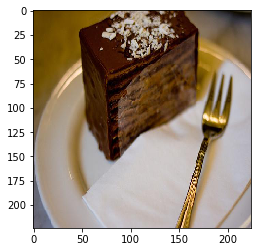

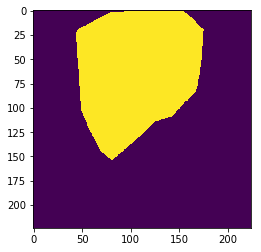

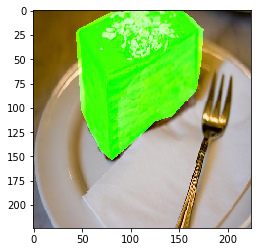

In [39]:
# random_idx = 10
for random_idx in range(1):
    plt.imshow(pic_2_mask_2_prev_list[random_idx][0])
    plt.figure()
    plt.imshow(pic_2_mask_2_prev_list[random_idx][1])
    plt.figure()
    plt.imshow(pic_2_mask_2_prev_list[random_idx][2])

    plt.show()

In [40]:
pics_raw = np.stack([pic for (pic,_,_) in pic_2_mask_2_prev_list])
masks_raw = np.stack([mask for (_,mask,_) in pic_2_mask_2_prev_list])

In [41]:
pics = np.transpose(pics_raw,(0,3,1,2))
masks = np.expand_dims(masks_raw,axis=1)

In [42]:
print(pics.shape)
print(masks.shape)

(2548, 3, 224, 224)
(2548, 1, 224, 224)


In [43]:
scaled_masks = scale_masks(masks)

# train_pics = normalize_imgs(pics)
nr_train = 2000
train_pics = pics[:nr_train]
train_masks = scaled_masks[:nr_train]

test_pics = pics[nr_train:]
test_masks = scaled_masks[nr_train:]


In [44]:
model = get_unet(224,224)

In [ ]:
# save_path = "/home/docker/fastai-courses/deeplearning1/nbs/persistent/coco/detection/food2-dataset-4cls/models/"
# model.load_weights(save_path+"unet_4e.h5")

In [52]:
model.fit(train_pics, 
          train_masks, 
          batch_size=32, 
          nb_epoch=1,
          validation_data = (test_pics,test_masks)
         )

Train on 2000 samples, validate on 548 samples
Epoch 1/1
2000/2000 [==============================] - 96s - loss: 112.6637 - acc: 0.0036 - val_loss: 114.6564 - val_acc: 0.0025

In [53]:
save_path = "/home/docker/fastai-courses/deeplearning1/nbs/persistent/coco/detection/food2-dataset-4cls/models/"
model.save_weights(save_path+"unet_3e_bn.h5")

In [54]:
no_predictions = 30

data_to_predict = test_pics[:no_predictions]
plot_masks = test_masks[:no_predictions]

predictions = model.predict(data_to_predict)
predictions.shape

(30, 1, 224, 224)

In [58]:
plotPredictedVsReality(predictions, data_to_predict,plot_masks, 0,no_predictions)

In [57]:
for raw_pred in predictions:
    squeezed_pred = np.squeeze(raw_pred)
    plt.imshow(squeezed_pred, cmap='Greys',  interpolation='nearest')  
    plt.figure()
plt.show()